## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

## Placeholder for Table of Contents Bug on AWS

# Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
from pprint import pprint

from PIL import Image

import gc
import optuna
from sklearn.feature_selection import RFE
from math import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import tanh
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation,Dense,Dropout, Conv2D, Concatenate, LeakyReLU, MaxPooling2D, Reshape, Input, LSTM

/tmp/ipykernel_26212/2343924658.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-13 01:09:26.630106: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-13 01:09:27.196532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AV

In [2]:
df = pd.read_csv('/home/ec2-user/Capstone/pair_features1_300_15.csv')
df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,abs_spread_normed_max,abs_spread_normed_90th,abs_spread_normed_75th,abs_spread_normed_median,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,num_entries
0,2015-01-02,SLB,66.153,GRMN,39.250,86.200,53.140,84.620,52.320,5500800.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,SLB,64.361,GRMN,38.167,84.400,52.410,82.590,51.080,10039400.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,SLB,63.103,GRMN,37.705,83.360,51.250,80.660,50.080,9758400.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-07,SLB,63.095,GRMN,38.406,82.660,51.980,80.530,51.340,7951600.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-08,SLB,63.859,GRMN,38.406,83.290,51.870,81.940,50.960,7911600.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
sector_df = pd.read_csv('/home/ec2-user/Capstone/1999-12-01-2023-12-31.csv')

In [4]:
print(df.shape)
sector_df = sector_df[['Date','Ticker','Open','Close','Adj Close']]
sector_df.columns = ['Date','Ticker_P1','Open_P1','Close_P1','Adj Close_P1']
df = pd.merge(df,sector_df,\
                     on=['Date','Ticker_P1'],how='left',suffixes=[None,'_y'])
print(df.shape)
sector_df.columns = ['Date','Ticker_P2','Open_P2','Close_P2','Adj Close_P2']
df = pd.merge(df,sector_df,\
                     on=['Date','Ticker_P2'],how='left',suffixes=[None,'_y'])
df.shape

(1257000, 27)
(1257000, 30)


(1257000, 33)

In [5]:
df['pnls'] = df['pnls']*100.0

In [6]:
total_days = df.Date.nunique()
total_days

1257

In [7]:
print(df.shape)
df.isna().sum()

(1257000, 33)


Date                              0
Ticker_P1                         0
Close_P1                          0
Ticker_P2                         0
Close_P2                          0
High_P1                           0
High_P2                           0
Low_P1                            0
Low_P2                            0
Volume_P1                         0
Volume_P2                         0
abs_spread                        0
abs_spread_mean              299000
abs_spread_std               299000
abs_spread_mean_l28           27000
abs_spread_std_l28            27000
spread_normed                299000
abs_spread_normed_max        598000
abs_spread_normed_90th       598000
abs_spread_normed_75th       598000
abs_spread_normed_median     598000
abs_spread_normed_l7_avg     305000
abs_spread_normed_l14_avg    312000
cos_sim                      299000
corr_coef                    299000
pnls                         315000
num_entries                  315000
Open_P1                     

In [8]:
df.Date.nunique()

1257

In [9]:
df.abs_spread_normed_max.dropna().describe()

count   659000.000
mean         3.219
std          0.743
min          1.096
25%          2.718
50%          3.138
75%          3.578
max          7.090
Name: abs_spread_normed_max, dtype: float64

In [10]:
tmp_df = df[(df.Ticker_P1 == 'TDY') & (df.Ticker_P2 == 'PEP')]
tmp_df.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,cos_sim,corr_coef,pnls,num_entries,Open_P1,Close_P1_y,Adj Close_P1,Open_P2,Close_P2_y,Adj Close_P2


In [11]:
tmp_df.abs_spread_normed_max

Series([], Name: abs_spread_normed_max, dtype: float64)

In [12]:
df = df.sort_values('Date')

In [13]:
print(df.Date.min(),df.Date.max())

2015-01-02 2019-12-30


# Bad Data

In [14]:
print(df.shape)
df = df[df['Volume_P1']>0]
print(df.shape)
df = df[df['Volume_P2']>0]
print(df.shape)


(1257000, 33)
(1257000, 33)
(1255183, 33)


In [15]:
df = df[df['abs_spread']>=1]
print(df.shape)

(1232286, 33)


In [16]:
df.tail(2)

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,High_P1,High_P2,Low_P1,Low_P2,Volume_P1,...,cos_sim,corr_coef,pnls,num_entries,Open_P1,Close_P1_y,Adj Close_P1,Open_P2,Close_P2_y,Adj Close_P2
843446,2019-12-30,GRMN,88.556,ENPH,25.370,98.630,26.850,97.630,25.230,429500.000,...,0.909,0.625,NaN,NaN,98.470,97.950,88.556,26.710,25.370,25.370
1256999,2019-12-30,TYL,298.360,NWS,13.808,300.900,14.500,294.780,14.410,300500.000,...,0.993,0.633,NaN,NaN,300.160,298.360,298.360,14.420,14.460,13.808


# Label

In [17]:
# df['abs_spread_mean'] = df['abs_spread_mean_l20']

for i in range(17,20):
    df['FUTURE_abs_spread_'+str(i)] = df.groupby(['Ticker_P1','Ticker_P2'])['abs_spread'].shift(-1*i)

df['FUTURE_abs_spread_avg'] = df[[c for c in df.columns if 'FUTURE_abs_spread_' in c]].mean(axis=1)

df['PCT_CHANGE'] = (df['FUTURE_abs_spread_avg'] - df['abs_spread'])*100.0/df['abs_spread']
# df['direction'] = np.where(df['PCT_CHANGE'].abs()<3,0,np.where(df['PCT_CHANGE']>0,1,-1))
# df['direction'] = np.where((df['FUTURE_abs_spread_avg'] - (df['abs_spread_mean']+1.5*df['abs_spread_std']))>0,1,0)
df['direction'] = np.where((df['FUTURE_abs_spread_avg'] - (df['abs_spread_mean']+0.1*df['abs_spread_std']))<0,1,0)

df['direction'].value_counts()
# df['direction'] = df['PCT_CHANGE']

direction
0    867089
1    365197
Name: count, dtype: int64

# Feature Engineering

In [18]:
all_pairs = df[['Ticker_P1','Ticker_P2']].drop_duplicates()
all_pairs

,Ticker_P1,Ticker_P2
0,SLB,GRMN
913839,GRMN,PODD
87990,SLB,EXR
915096,GRMN,WBA
916353,GRMN,CCI
...,...,...
789400,GRMN,GIS
926415,GRMN,ADM
903789,GRMN,LUV
897506,GRMN,L


In [19]:
for c in ['Open','Low','High']:
    for p in ['1','2']:
        df[c+'_P'+p] = np.where(df['Adj Close_P'+p]!=df['Close_P'+p+'_y'],\
                                df['Adj Close_P'+p]*df[c+'_P'+p]/df['Close_P'+p+'_y'],\
                                df[c+'_P'+p])

In [20]:
df['Date'] = pd.to_datetime(df.Date)

In [21]:
from pathlib import Path

X = []
y = []

count = 0
for i in range(301,df.Date.nunique()-120):
    for ticker1, ticker2 in tqdm(all_pairs.values):

        f_name = ticker1+'_'+ticker2+'_'+'2017-05-23'
#         fig.write_image("/home/ec2-user/Capstone/Image/"+f_name+".png") 
        
#         try:

        path = "/home/ec2-user/Capstone/Image/"+f_name+".png"
        my_file = Path(path)

        if my_file.is_file()==False:
            continue
        image = Image.open(path)
        image_arr = np.asarray(image)



        target_df = df[(df.Ticker_P1 == ticker1) & (df.Ticker_P2 == ticker2) & (df.Date==pd.to_datetime('2017-05-23'))]
        
        if target_df.shape[0] == 0:
            continue
            
        label = target_df['direction'].iloc[0]
#             print(label)
        X.append(image_arr)

        y.append(label)
        
        del image
#         except:
#             pass
        count += 1
        if count >= 1000:
            break
        #         fig.show()
#         break
    break

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
# STOP

In [23]:
df[(df.Ticker_P1 == ticker1) & (df.Ticker_P2 == ticker2) & (df.Date==pd.to_datetime('2017-05-23'))]['direction']

777427    0
Name: direction, dtype: int64

In [24]:
X = [image * (255.0/image.max()) for image in tqdm(X)]

  0%|          | 0/982 [00:00<?, ?it/s]

In [25]:
X = np.array(X)
y = np.array(y)

In [26]:
X = X.reshape((X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))

In [27]:
print(X.shape)
print(y.shape)

(982, 500, 700, 4, 1)
(982,)


In [28]:
pd.Series(y).value_counts()

0    579
1    403
Name: count, dtype: int64

In [29]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42,shuffle=True)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=True)

In [ ]:
import gc
gc.collect()

In [32]:
def shuffle(matrix, target, test_proportion):
    ratio = int(matrix.shape[0]/test_proportion) #should be int
    X_train = matrix[ratio:,:,:,:,:]
    X_test =  matrix[:ratio,:,:,:,:]
    Y_train = target[ratio:]
    Y_test =  target[:ratio]
    return X_train, X_test, Y_train, Y_test

X_train, X_test, y_train, y_test = shuffle(X, y, 3)
X_val, X_test, y_val, y_test = shuffle(X_test, y_test, 2)

In [33]:
# # undersample = RandomUnderSampler(sampling_strategy='not minority')
# undersample = RandomUnderSampler(sampling_strategy='majority')

# X_train, y_train = undersample.fit_resample(X_train, y_train)
# X_val, y_val = undersample.fit_resample(X_val, y_val)

# sample_size = pd.Series(y_train).value_counts().min()
# idx = np.random.choice(np.arange(len(x)), sample_size, replace=False)

# X_train_1s = X_train[y==1]
# X_train = X_train[X_train==[idx]
# y_sample = y[idx]

In [34]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_val).value_counts())
print(pd.Series(y_test).value_counts())

0    356
1    299
Name: count, dtype: int64
0    114
1     50
Name: count, dtype: int64
0    109
1     54
Name: count, dtype: int64


In [35]:
from tensorflow.keras import layers

def get_model(width=500, height=700, depth=4):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=32, kernel_size=4, activation="relu",padding='same')(inputs)
    x = layers.MaxPool3D(pool_size=2,padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=4, activation="relu",padding='same')(x)
    x = layers.MaxPool3D(pool_size=2,padding='same')(x)
    x = layers.BatchNormalization()(x)

#     x = layers.Conv3D(filters=128, kernel_size=4, activation="relu",padding='same')(x)
#     x = layers.MaxPool3D(pool_size=2,padding='same')(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.Conv3D(filters=256, kernel_size=4, activation="relu",padding='same')(x)
#     x = layers.MaxPool3D(pool_size=2,padding='same')(x)
#     x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs)
    return model

model = get_model(width=500, height=700, depth=4)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 700, 4, 1)   0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 500, 700, 4, 32)   2080      
                                                                 
 max_pooling3d (MaxPooling3  (None, 250, 350, 2, 32)   0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 250, 350, 2, 32)   128       
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 250, 350, 2, 32)   65568     
                                                             

2024-03-13 01:13:08.141739: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [36]:
from tensorflow import keras
from keras import optimizers
# keras.optimizers.RMSprop(lr=1e-4)
adam = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])


In [37]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.9199438202247191, 1: 1.0953177257525084}

In [38]:
history = model.fit(X_train,y_train,\
                   epochs=5,\
                   batch_size=8,\
                   validation_data=(X_val,y_val),\
                   verbose=1,\
#                    callbacks=[earlystopper],\
                   shuffle=True,
                    class_weight=class_weight_dict
                  )

Epoch 1/5
82/82 [==============================] - 147s 2s/step - loss: 0.6915 - acc: 0.5573 - val_loss: 1.4519 - val_acc: 0.3049
Epoch 2/5
82/82 [==============================] - 146s 2s/step - loss: 0.6910 - acc: 0.5664 - val_loss: 0.7425 - val_acc: 0.3049
Epoch 3/5
82/82 [==============================] - 145s 2s/step - loss: 0.6906 - acc: 0.5878 - val_loss: 0.6577 - val_acc: 0.6890
Epoch 4/5
82/82 [==============================] - 145s 2s/step - loss: 0.6912 - acc: 0.5511 - val_loss: 0.6591 - val_acc: 0.6951
Epoch 5/5
82/82 [==============================] - 145s 2s/step - loss: 0.6896 - acc: 0.5832 - val_loss: 0.6647 - val_acc: 0.7012


In [39]:
preds = model.predict(X_test)

6/6 [==============================] - 9s 1s/step


In [40]:
preds = np.where(preds.flatten()>0.5,1,0)

In [41]:
print('weighted f1: ', f1_score(y_test, preds, average='weighted'))
print('micro f1: ', f1_score(y_test, preds, average='micro'))
print('macro f1: ', f1_score(y_test, preds, average='macro'))

weighted f1:  0.5436103772327939
micro f1:  0.6625766871165644
macro f1:  0.41531337637774735


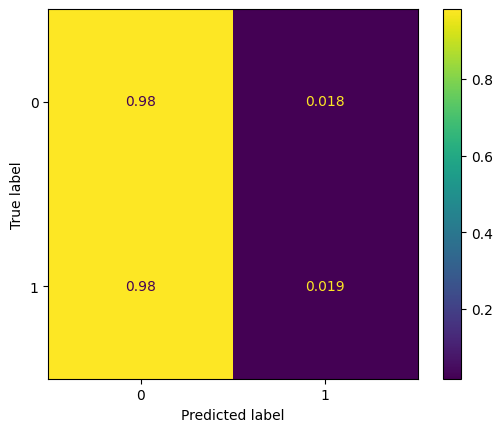

In [42]:
cm = confusion_matrix(y_test, preds, labels=[0,1],normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()